In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog 
from numpy.linalg import solve
import urllib.request
import os
import day_ahead
import pulp as plp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

### Downloading and parsing data for Consumption Prognosis

In [2]:
if not os.path.exists('data'):
    os.makedirs('data')

#Consumption prognosis data source on Nord Pool's website
url = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/consumption-prognosis_2019_hourly.xls" 
urllib.request.urlretrieve(url, 'data/consumption.xls');

#Convert de .xls file into a Data Frame
consumptionProg_raw_data = pd.read_html('data/consumption.xls')[0].values
consumptionProg_df = pd.DataFrame(consumptionProg_raw_data)
consumptionProg_df.columns = ['Dates', 'Hours', 'NO', 'SE', 'FI', 'DK1', 'DK2', 'EE', 'LV', 'LT']
consumptionProg_df = consumptionProg_df[['Dates', 'Hours', 'DK1', 'DK2']]
consumptionProg_df['Hours'] = consumptionProg_df['Hours'].str.slice(stop=2)
consumptionProg_df['ts'] = pd.to_datetime(consumptionProg_df['Dates'] + consumptionProg_df['Hours'] + ':00', format='%d-%m-%Y%H:%M')
consumptionProg_df = consumptionProg_df[consumptionProg_df['ts'] < pd.to_datetime('2019-02-01')]

## Including Import of DK1 <- Norway (200MW)
consumptionProg_df['DK1'] = consumptionProg_df['DK1'] - 200

## Including Export of DK1 -> Germany (100MW)
for i in consumptionProg_df.index:
    if (consumptionProg_df['ts'][i].time() >= pd.to_datetime('07:00:00').time()) & (consumptionProg_df['ts'][i].time() < pd.to_datetime('14:00:00').time()):
        consumptionProg_df['DK1'][i] = consumptionProg_df['DK1'][i] + 100
        
## Including Import of DK2 <- Sweden (150MW)
for i in consumptionProg_df.index:
    if (consumptionProg_df['ts'][i].time() >= pd.to_datetime('13:00:00').time()) & (consumptionProg_df['ts'][i].time() < pd.to_datetime('19:00:00').time()):
        consumptionProg_df['DK2'][i] = consumptionProg_df['DK2'][i] - 150

C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Downloading and parsing data for Wind Power Generation Prognosis

In [3]:
#Wind power generation prognosis data source on Nord Pool's website
url2 = "http://www.nordpoolspot.com/globalassets/marketdata-excel-files/wind-power-dk-prognosis_2019_hourly.xls" 
urllib.request.urlretrieve(url2, 'data/wind-prognosis.xls');

#Convert de .xls file into a Data Frame
windProg_raw_data = pd.read_html('data/wind-prognosis.xls')[0].values
windProg_df = pd.DataFrame(windProg_raw_data)
windProg_df.columns = ['Dates', 'Hours', 'DK1', 'DK2']
windProg_df['Hours'] = windProg_df['Hours'].str.slice(stop=2)
windProg_df['ts'] = pd.to_datetime(windProg_df['Dates'] + windProg_df['Hours'] + ':00', format='%d-%m-%Y%H:%M')
windProg_df = windProg_df[windProg_df['ts'] < pd.to_datetime('2019-02-01')]

#Set the proportion of wind power generation to each producer in each region
windProg_df['WW1'] = windProg_df['DK1']*(1/4)
windProg_df['WW2'] = windProg_df['DK1']*(3/4)
windProg_df['EW1'] = windProg_df['DK2']*(1/3)
windProg_df['EW2'] = windProg_df['DK2']*(2/3)
#Remove unwanted columns from Dataframe
windProg_df = windProg_df.drop(['Dates', 'Hours', 'DK1', 'DK2'], axis=1)

In [4]:
#List of all energy suppliers by region with their respective offers (energy quantity and bid price)
region_g = ['DK1', 'DK1', 'DK2', 'DK2', 'DK1', 'DK1', 'DK1', 'DK1', 'DK1', 'DK1','DK1', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2', 'DK2']
cost_g = np.array([0, -17, -20, -12, 70, 64, 153, 82, 89, 25, 250, 19, 43, 39, 36, 31, 5, 10, 250])
power_g_all = np.array([400, 330, 345, 390, 510, 1000, 900, 1200, 320, 360, 400, 350, 730, 630, 800])
#Array considering time restriction of some generators
power_g_rest = np.array([400, 330, 345, 390, 510, 0, 900, 0, 320, 360, 400, 350, 730, 630, 800])

generationProg_df = windProg_df

#Include the supplier energy offers into the generation dataframe according to their time of operation
for i in range(15):
    generationProg_df['G{}'.format(i+1)] = power_g_rest[i]
    
for i in generationProg_df.index:
    if (generationProg_df['ts'][i].time() >= pd.to_datetime('05:00:00').time()) & (generationProg_df['ts'][i].time() < pd.to_datetime('22:00:00').time()):
        generationProg_df['G6'][i] = power_g_all[5]
        generationProg_df['G8'][i] = power_g_all[7]

C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
#Solve the optimization problem for every time slot of the day-ahead market using the demand and supply offers
#A function named 'day_ahead.solver' was created to solve the linear programming optimization problem
    #INPUT: generation (DF), demand (DF) and interconnection limitaiton.
    #OUTPU: scheduled generation (DF), scheduled demand (DF) and amount of interconnection used
schedule_g = {}
schedule_d = {}
price = {}

limit = 600

#Arrange the data from generation and consumption prognosis into dataframes in the correct structure to be utilized by the function
for i in range(len(consumptionProg_df)):
    g_df = pd.DataFrame({'ID' : list(generationProg_df)[1:],
                         'region' : region_g,
                         'power_g' : generationProg_df[list(generationProg_df)[1:]].values[i],
                         'cost_g' : cost_g})

    d_df = pd.DataFrame({'ID' : ['D1','D2'],
                         'region' : list(consumptionProg_df)[2:-1],
                         'power_d' : consumptionProg_df[list(consumptionProg_df)[2:-1]].values[i],
                         'cost_d' : [99999, 99999]})
    
    schedule_g[consumptionProg_df['ts'][i]], schedule_d[consumptionProg_df['ts'][i]], price[consumptionProg_df['ts'][i]] = day_ahead.solver(g_df, d_df, limit)
 


## Adjusting market price for wind farms with support schemes

In [6]:
#Add the respective support scheme for each wind power generation to calculate their revenues
for key in schedule_g.keys():
    schedule_g[key]['Market Price'][1] = price[key]['DK1'] + 17
    schedule_g[key]['Market Price'][9] = 20
    schedule_g[key]['Market Price'][10] = price[key]['DK2'] + 12
    schedule_g[key]['Revenue'] = schedule_g[key]['Market Price'] * schedule_g[key]['Scheduled Pg']

C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\lucas\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Suppliers Dictionary

In [7]:
suppliers_dict = {'WW1' : 'WestWind1',
                 'WW2' : 'WestWind2',
                 'G1' : 'FlexiGas',
                 'G2' : 'FlexiGas',
                 'G3' : 'FlexiGas',
                 'G4' : 'Peako',
                 'G5' : 'Peako',
                 'G6' : 'Nuke22',
                 'G7' : 'CoalAtLast',
                 'EE1' : 'EastWind1',
                 'EE2' : 'EastWind2',
                 'G8' : 'Nuke22',
                 'G9' : 'RoskildeCHP',
                 'G10' : 'RoskildeCHP',
                 'G11' : 'Avedovre',
                 'G12' : 'Avedovre',
                 'G13' : 'BlueWater',
                 'G14' : 'BlueWater',
                 'G15' : 'CoalAtLast'}

## Verifying congestion in the interconnection

In [8]:
#We check the congestion of the interconnection by analyzing the difference of scheduled energy for consumption and demand on DK1
congestion_df = pd.DataFrame()
for key in schedule_d.keys():
    
    DK1_supply = schedule_g[key][schedule_g[key]['Region'] == 'DK1']['Scheduled Pg'].sum()
    DK1_demand = schedule_d[key][schedule_d[key]['Region'] == 'DK1']['Scheduled Pd'].sum()

    energy_exchanged = DK1_supply - DK1_demand

    if abs(energy_exchanged) == limit:
        congestion = 1
    else:
        congestion = 0
    
    congestion_df = congestion_df.append({'ts': key,
                                          'Energy Exchanged' : energy_exchanged,
                                          'Congestion' : congestion}, ignore_index=True)

print('The interconnection was congested in {} timesteps (hours).'.format(congestion_df['Congestion'].sum()))    

print('Which represents aproximetely {} % of the analyzed period.'.format(round(100*congestion_df['Congestion'].sum()/len(congestion_df['Congestion']))))    


The interconnection was congested in 511.0 timesteps (hours).
Which represents aproximetely 69.0 % of the analyzed period.


## Calculating suppliers revenues

In [9]:
#Revenues are calculated considering each the scheduled quantities for each supplier and market price for each time slot
revenue_df = pd.concat([pd.DataFrame(schedule_g[key]['Revenue'].values, columns=[key]) for key in schedule_g.keys()], axis = 1)
revenue_df.index = suppliers_dict.keys()
print('Suppliers Revenues: \n')
print(revenue_df.sum(axis=1))
print('\nTotal: {}'.format(revenue_df.sum(axis=1).sum()))
total_revenue = revenue_df.sum(axis=1).sum()

Suppliers Revenues: 

WW1    5.678087e+06
WW2    3.136378e+07
G1     3.670740e+06
G2     5.534338e+06
G3     0.000000e+00
G4     1.142750e+06
G5     1.982920e+05
G6     1.441250e+07
G7     0.000000e+00
EE1    2.357553e+06
EE2    5.268758e+06
G8     5.894364e+06
G9     0.000000e+00
G10    1.848600e+04
G11    4.615200e+05
G12    1.187862e+06
G13    8.825185e+06
G14    7.218610e+06
G15    0.000000e+00
dtype: float64

Total: 93232827.8332606


# Calculating Payments

In [10]:
#Revenues are calculated considering each the scheduled quantities for each supplier and market price for each time slot
payments_df = pd.concat([pd.DataFrame(schedule_d[key]['Payment'].values, columns=[key]) for key in schedule_d.keys()], axis = 1)
payments_df.index = ['DK1', 'DK2']
print('Payments: \n')
print(payments_df.sum(axis=1))
print('\nTotal: {}'.format(payments_df.sum(axis=1).sum()))
total_payments = payments_df.sum(axis=1).sum()

Payments: 

DK1    61197884.0
DK2    21013517.0
dtype: float64

Total: 82211401.0


# Calculating Payments

In [11]:
total_payments - total_revenue

-11021426.833260596

# Calculating schedule frequency

In [12]:
schedule_frequency_df = pd.concat([pd.DataFrame(schedule_g[key]['Scheduled Pg'].values, columns=[key]) for key in schedule_d.keys()], axis = 1)
schedule_frequency_df.index = suppliers_dict.keys()
print('Total Schedule: \n')
print(schedule_frequency_df.sum(axis=1))

Total Schedule: 

WW1    249973.750000
WW2    913511.500000
G1      47302.000000
G2      76177.000000
G3          0.000000
G4      13370.000000
G5       2228.000000
G6     259460.000000
G7          0.000000
EE1    117877.666534
EE2    227602.083477
G8     293556.000000
G9          0.000000
G10       474.000000
G11     12720.000000
G12     34152.000000
G13    450307.000000
G14    331576.000000
G15         0.000000
dtype: float64


## Checking if load shedding happened

In [13]:
#Check amount of load shedding by analyzing if the demand was ever greater than the supply for each region
demand_scheduled = pd.concat([pd.DataFrame([schedule_d[key]['Scheduled Pd'].sum()], columns=[key]) for key in schedule_d.keys()], axis = 1).T

load_shedding = pd.DataFrame({'ts' : consumptionProg_df['ts'],
                              'Total Demand' : consumptionProg_df['DK1'] + consumptionProg_df['DK2'],
                              'Scheduled Demand' : demand_scheduled[0].values})

load_shedding['Difference'] = load_shedding['Total Demand'] - load_shedding['Scheduled Demand']
print('Total load shedding: {} MWh'.format(load_shedding['Difference'].sum()))

Total load shedding: 0.0 MWh


## Checking days with high and low wind penetration

In [14]:
#High wind penetration: Wind power production to meet demand
#Low wind penetration: lowest ration between the wind energy produced by the total consumption of any given time slot
wind_generation = pd.concat([pd.DataFrame([schedule_g[key]['Scheduled Pg'][0] + schedule_g[key]['Scheduled Pg'][1] + schedule_g[key]['Scheduled Pg'][9] + schedule_g[key]['Scheduled Pg'][10]], columns=[key]) for key in schedule_d.keys()], axis = 1).T

WP = pd.DataFrame({'ts' : load_shedding['ts'],
                                 'Demand' : load_shedding['Scheduled Demand'],
                                 'Wind Suply' : wind_generation[0].values})
daily_WP = WP.set_index('ts').resample('D').agg(['sum'])

WP['WP'] = WP['Wind Suply']/WP['Demand']
daily_WP['WP'] = daily_WP['Wind Suply']/daily_WP['Demand']

day_max_WP = daily_WP['WP'].idxmax()
day_min_WP = daily_WP['WP'].idxmin()

daily_WP_max = daily_WP['WP'][day_max_WP]
daily_WP_min = daily_WP['WP'][day_min_WP]

high_day_df = WP.set_index('ts').loc['2019-01-01 00:00:00':'2019-01-01 23:59:59']
low_day_df = WP.set_index('ts').loc['2019-01-20 00:00:00':'2019-01-20 23:59:59']


high_ts = pd.to_datetime('2019-01-01 11:00:00')
low_ts = WP.set_index('ts').loc['2019-01-20 00:00:00':'2019-01-20 23:59:59']['WP'].idxmin()

#Since the consumption was met by the wind power production in different days, one was selected
#HIGH WP: 01/01/2019 at 11:00 AM
#LOW WP: 20/01/2019 at 11:00 AM

# How often are the conventional generators scheduled?

In [15]:
conventional_frequency = len(WP[WP['WP'] != 1])
conventional_frequency

684

# Wind Curtailment

In [16]:
data = generationProg_df.set_index('ts')
wind_curtailment = pd.concat([pd.DataFrame([data.loc[key]['WW1'] + data.loc[key]['WW2'] + data.loc[key]['EW1'] + data.loc[key]['EW2']], columns=[key]) for key in data.index.values], axis = 1).T
wind_curtailment['wind scheduled'] = WP['Wind Suply'].values

wind_curtailment['diff'] = wind_curtailment[0] - wind_curtailment['wind scheduled']
wind_curtailment = wind_curtailment.round({'diff': 0})

hours_curtailment = len(wind_curtailment[wind_curtailment['diff'] != 0])
energy_curtailment = wind_curtailment[wind_curtailment['diff'] != 0]['diff'].sum()

print('Wind curtailment occured {} hours.'.format(hours_curtailment))
print('Resulting in curtailment of {} MWh'.format(energy_curtailment))


Wind curtailment occured 121 hours.
Resulting in curtailment of 68845.0 MWh


## Plotting the prices of high and low Wind Power Penetration days

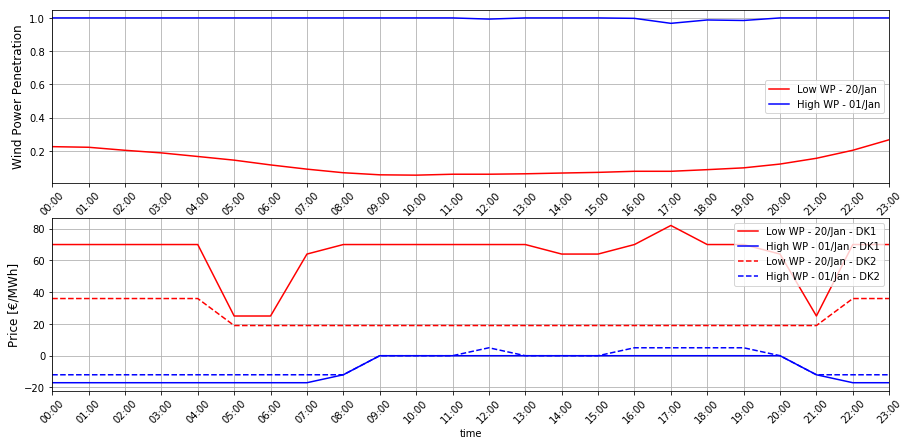

In [17]:
prices_DK1 = pd.concat([pd.DataFrame([schedule_d[key]['Market Price'][0]], columns=[key]) for key in schedule_d.keys()], axis = 1).T
prices_DK2 = pd.concat([pd.DataFrame([schedule_d[key]['Market Price'][1]], columns=[key]) for key in schedule_d.keys()], axis = 1).T

fig = plt.figure(figsize=(15,7))

y1 = prices_DK1.loc['2019-01-20 00:00:00':'2019-01-20 23:59:59'][0].values
x1 = prices_DK1.loc['2019-01-20 00:00:00':'2019-01-20 23:59:59'][0].index.time

y2 = prices_DK1.loc['2019-01-01 00:00:00':'2019-01-01 23:59:59'][0].values
x2 = prices_DK1.loc['2019-01-01 00:00:00':'2019-01-01 23:59:59'][0].index.time

y3 = low_day_df.WP.values
x3 = low_day_df.index.time

y4 = high_day_df.WP.values
x4 = high_day_df.index.time

y5 = prices_DK2.loc['2019-01-20 00:00:00':'2019-01-20 23:59:59'][0].values
x5 = prices_DK2.loc['2019-01-20 00:00:00':'2019-01-20 23:59:59'][0].index.time

y6 = prices_DK2.loc['2019-01-01 00:00:00':'2019-01-01 23:59:59'][0].values
x6 = prices_DK2.loc['2019-01-01 00:00:00':'2019-01-01 23:59:59'][0].index.time

plt.subplot(2,1,1)
plt.plot(x3, y3, color = 'red')
plt.plot(x4, y4, color = 'blue')
plt.ylabel('Wind Power Penetration', fontsize = 'large')
plt.xlim(['00:00:00','23:00:00'])
plt.xticks(x1, rotation = 45)
plt.grid()
plt.legend(['Low WP - 20/Jan', 'High WP - 01/Jan'])

plt.subplot(2,1,2)
plt.plot(x1, y1, color = 'red')
plt.plot(x2, y2, color = 'blue')
plt.plot(x5, y5, color = 'red', linestyle= '--')
plt.plot(x6, y6, color = 'blue', linestyle= '--')
plt.ylabel('Price [\u20ac/MWh]', fontsize = 'large')
plt.xlim(['00:00:00','23:00:00'])
plt.xticks(x3, rotation = 45)
plt.grid()
plt.legend(['Low WP - 20/Jan - DK1', 'High WP - 01/Jan - DK1','Low WP - 20/Jan - DK2', 'High WP - 01/Jan - DK2'])
plt.show()

## Plot of congestion

In [18]:
TOT = len(congestion_df)
DK12 = 100*len(congestion_df[congestion_df['Energy Exchanged'] > 0])/TOT
DK21 = 100*len(congestion_df[congestion_df['Energy Exchanged'] < 0])/TOT
print('DK1 exports energy {}% of the time'.format(DK12))
print('DK2 exports energy {}% of the time'.format(DK21))

DK1 exports energy 29.43548387096774% of the time
DK2 exports energy 70.56451612903226% of the time


C:\Users\lucas\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


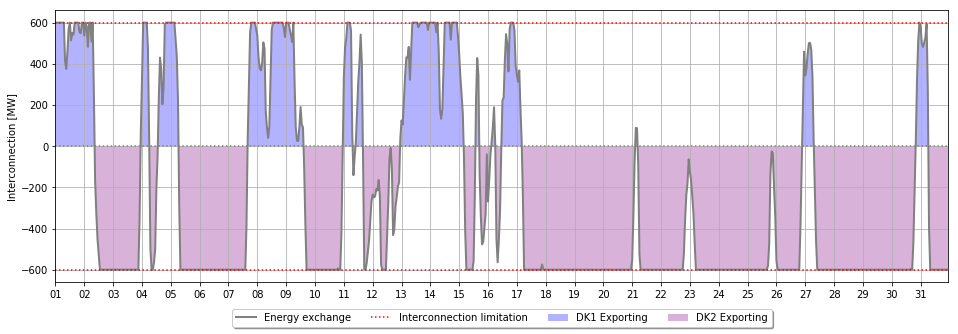

In [19]:
time = congestion_df['ts'].values
congestion = congestion_df['Energy Exchanged'].values

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(time, congestion, lw=2, color='grey')
ax.fill_between(time, congestion, 0, where=congestion >= 0, facecolor='blue', interpolate=True, alpha=0.3)
ax.fill_between(time, congestion, 0, where=congestion <= 0, facecolor='purple', interpolate=True, alpha=0.3)
ax.axhline(600, linestyle = ':' ,color = 'red')
ax.legend(['Energy exchange', 'Interconnection limitation', 'DK1 Exporting','DK2 Exporting'], loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)
ax.axhline(-600, linestyle = ':' ,color = 'red')
ax.axhline(0, linestyle = ':', color = 'grey')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlim(time[0], time[-1])
ax.set_ylabel('Interconnection [MW]')
ax.grid()

fig.show()

# Prices

In [20]:
prices_df = pd.DataFrame(price).T
prices_df['hour'] = prices_df.index.time
prices_DK1_df = prices_df.groupby('hour').aggregate({'DK1': ['min', 'max', 'mean']})
prices_DK2_df = prices_df.groupby('hour').aggregate({'DK2': ['min', 'max', 'mean']})

Text(0, 0.5, 'Price [€/MWh]')

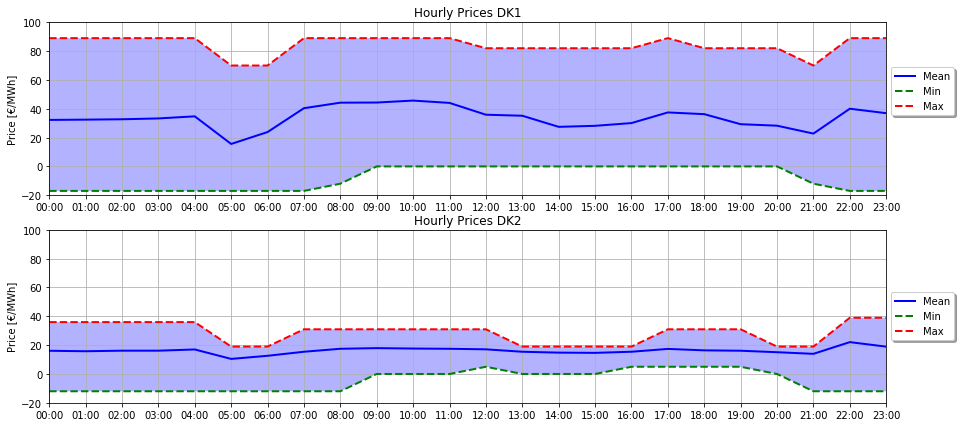

In [21]:
DK1_min = prices_DK1_df.values[:,0]
DK1_max = prices_DK1_df.values[:,1]
DK1_mean = prices_DK1_df.values[:,2]

DK2_min = prices_DK2_df.values[:,0]
DK2_max = prices_DK2_df.values[:,1]
DK2_mean = prices_DK2_df.values[:,2]

t = prices_DK1_df.index.values

# plot it!
fig = plt.figure(figsize=(15,7))

ax = plt.subplot(2,1,1)
ax.set_title('Hourly Prices DK1')

ax.plot(t, DK1_mean, lw=2, label='Mean', color='blue')
ax.fill_between(t, DK1_max, DK1_min, facecolor='blue', alpha=0.3, interpolate=True,)
ax.plot(t, DK1_min, lw=2, label='Min', color='green', linestyle= '--')
ax.plot(t, DK1_max, lw=2, label='Max', color='red', linestyle= '--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.6),
          fancybox=True, shadow=True, ncol=1)
ax.set_xlabel('')
ax.set_xticks(t)
ax.set_xlim(['00:00:00','23:00:00'])
ax.grid()
ax.set_ylabel('Price [\u20ac/MWh]')
ax.set_ylim([-20,100])

ax = plt.subplot(2,1,2)
ax.set_title('Hourly Prices DK2')
ax.plot(t, DK2_mean, lw=2, label='Mean', color='blue')
ax.fill_between(t, DK2_max, DK2_min, facecolor='blue', interpolate=True, alpha=0.3)
ax.plot(t, DK2_min, lw=2, label='Min', color='green', linestyle= '--')
ax.plot(t, DK2_max, lw=2, label='Max', color='red', linestyle= '--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
ax.set_xlabel('')
ax.set_xticks(t)
ax.set_xlim(['00:00:00','23:00:00'])
ax.set_ylim([-20,100])
ax.grid()
ax.set_ylabel('Price [\u20ac/MWh]')